In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import parse_to_float, convert_date_format, apply_quantiles
import statsmodels.formula.api as smf
from config import token_keyword_mapping
import warnings
from IPython.display import display, HTML
warnings.filterwarnings('ignore')

In [27]:
def preprocess(data, filename):
    data = data.reindex(index=data.index[::-1])
    data['Date'] = data['Date'].apply(lambda x: convert_date_format(x))
    if 'btc' in filename or 'eth' in filename or 'bch' in filename or 'dash' in filename:
        data['Open'] = data['Open'].apply(parse_to_float)
    return data

In [28]:
def plot_price(data):
    plt.plot(data['Date'], data['Open'])
    plt.xticks(data['Date'][::300])
    plt.title(f'Price for {filename.split(".")[0].upper()}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

In [29]:
def get_daily_df(data):
    daily_df = data.copy()
    daily_df['Close'] = daily_df['Open'].shift(-1)
    daily_df['ReturnD'] = daily_df.apply(lambda x: (x['Close'] - x['Open']) / x['Open'] * 100, axis=1)
    return daily_df.dropna()

In [30]:
def plot_daily_df(daily_df):
    graph_data = daily_df[daily_df['ReturnD'] < 100]
    plt.hist(graph_data['ReturnD'], bins=200)
    plt.title(f'Daily Return Distribution for {filename.split(".")[0].upper()}')
    plt.xlabel('Daily Return x 100')
    plt.ylabel('Frequency')
    plt.show()

In [31]:
def get_weekly_df(data):
    weekly_df = data.copy()
    weekly_df = weekly_df.iloc[::7, :]
    weekly_df["CloseT+7"] = weekly_df['Open'].shift(-1)
    weekly_df['ReturnW'] = weekly_df.apply(lambda x: (x['CloseT+7'] - x['Open']) / x['Open'] * 100, axis=1)
    return weekly_df.dropna()

In [32]:
def plot_weekly_df(weekly_df):
    plt.hist(weekly_df['ReturnW'], bins=100)
    plt.title(f'Weekly Return Distribution for {filename.split(".")[0].upper()}')
    plt.xlabel('Weekly Return x 100')
    plt.ylabel('Frequency')
    plt.show()

In [33]:
def get_monthly_df(data):
    monthly_df = data.copy()
    monthly_df = monthly_df.iloc[::30, :]
    monthly_df["CloseT+30"] = monthly_df['Open'].shift(-1)
    monthly_df['ReturnM'] = monthly_df.apply(lambda x: (x['CloseT+30'] - x['Open']) / x['Open'] * 100, axis=1)
    return monthly_df.dropna()


In [34]:
def plot_monthly_df(monthly_df):
    plt.hist(monthly_df['ReturnM'], bins=25)
    plt.title(f'Monthly Return for Distribution {filename.split(".")[0].upper()}')
    plt.xlabel('Monthly Return x 100')
    plt.ylabel('Frequency')
    plt.show()

In [35]:
def add_google_data(tick_data, frequency):
    currency_name = token_keyword_mapping[filename.split('.')[0]]
    if frequency == 7:
        google_data = pd.read_csv(f"{folder+filename.split('.')[0]}_weekly_trends.csv")
    elif frequency == 1:
        google_data = pd.read_csv(f"{folder+filename.split('.')[0]}_trends.csv")
    google_data = google_data[['date', currency_name]]
    google_data = google_data.rename(columns={token_keyword_mapping[filename.split('.')[0]]: 'Google', 'date': 'Date'})
    return tick_data.merge(google_data, how='left', on='Date')

In [36]:
def get_daily_momentum(daily_df):
    daily_momentum = pd.DataFrame(columns=["rt_index", "beta", "t-statistic", "p<|t|", "r^2"])
    for i in range(1, 8):
        daily_df['period'] = daily_df['ReturnD'].shift(-1 * i)
        daily_df = daily_df.dropna()
        model = smf.ols('period ~ ReturnD', daily_df).fit()
        r2 = model.rsquared
        df = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]
        model_data = (df.iloc[[1]].values.tolist())
        beta = model_data[0][0]
        t = model_data[0][2]
        pt = model_data[0][3]
        daily_momentum.loc[len(daily_momentum)] = [i, beta, t, pt, r2]
    return daily_momentum

In [37]:
def get_weekly_momentum(weekly_df):
    weekly_momentum = pd.DataFrame(columns=["rt_index", "beta", "t-statistic", "p<|t|", "r^2"])
    for i in range(1, 5):
        weekly_df['period'] = weekly_df['ReturnW'].shift(-1 * i)
        weekly_df = weekly_df.dropna()
        model = smf.ols('period ~ ReturnW', weekly_df).fit()
        r2 = model.rsquared
        df = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]
        model_data = (df.iloc[[1]].values.tolist())
        beta = model_data[0][1]
        t = model_data[0][2]
        pt = model_data[0][3]
        weekly_momentum.loc[len(weekly_momentum)] = [i, beta, t, pt, r2]
    return weekly_momentum

In [38]:
def get_invatt_google_weekly(weekly_df):
    weekly_invatt_google = pd.DataFrame(columns=["rt_index", "beta", "t-statistic", "p<|t|", "r^2"])
    for i in range(1, 8):
        weekly_df['period'] = weekly_df['ReturnW'].shift(-1 * i)
        weekly_df = weekly_df.dropna()
        model = smf.ols('period ~ Google', weekly_df).fit()
        r2 = model.rsquared
        df = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]
        model_data = (df.iloc[[1]].values.tolist())
        beta = model_data[0][0]
        t = model_data[0][2]
        pt = model_data[0][3]
        weekly_invatt_google.loc[len(weekly_invatt_google)] = [i, beta, t, pt, r2]
    return weekly_invatt_google

In [60]:
def get_group_weekly_momentum(labels, weekly_df):
    weekly_momentum_group = pd.DataFrame(columns=["quintile_index", "rt_index", "average_ret", "t-statistic", "p<|t|", "r^2"])
    for rt_idx in range(1, 5):
        weekly_data = weekly_df.copy()
        weekly_data["rt"] = weekly_df['ReturnW'].shift(-1 * rt_idx)
        for quintile_idx in range(0, 5):
            quintile_data = weekly_data[weekly_data["quintile_idx"] == quintile_idx]
            quintile_data = quintile_data.dropna()
            model = smf.ols('rt ~ ReturnW'.format(rt_idx), quintile_data).fit()
            r2 = model.rsquared
            df = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]
            model_data = (df.iloc[[1]].values.tolist())
            avg_ret = quintile_data["rt"].mean()
            t = model_data[0][2]
            pt = model_data[0][3]
            weekly_momentum_group.loc[len(weekly_momentum_group)] = [labels[quintile_idx], rt_idx, avg_ret, t, pt, r2]
    return weekly_momentum_group

In [61]:
def get_group_invatt_google_weekly(labels, weekly_df):
    weekly_momentum_google_group = pd.DataFrame(columns=["quintile_index", "rt_index", "average_ret", "t-statistic", "p<|t|", "r^2"])
    for i in range(1, 5):
        weekly_data = weekly_df.copy()
        weekly_data['period'] = weekly_df['ReturnW'].shift(-1 * i)
        for quintile_idx in range(0, 5):
            quintile_data = weekly_data[weekly_data["quintile_google_idx"] == quintile_idx]
            quintile_data = quintile_data.dropna()
            model = smf.ols('period ~ Google', quintile_data).fit()
            r2 = model.rsquared
            df = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]
            model_data = (df.iloc[[1]].values.tolist())
            avg_ret = quintile_data['period'].mean()
            t = model_data[0][2]
            pt = model_data[0][3]
            weekly_momentum_google_group.loc[len(weekly_momentum_google_group)] = [labels[quintile_idx], i, avg_ret, t, pt, r2]
    return weekly_momentum_google_group

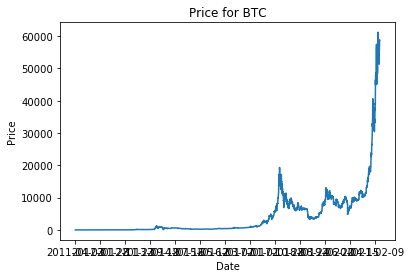

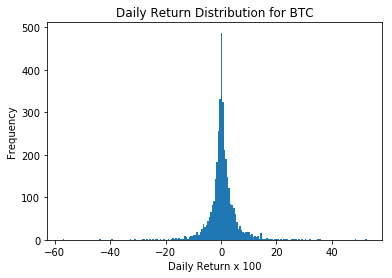

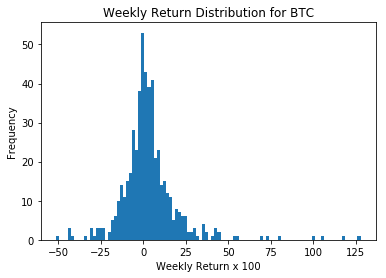

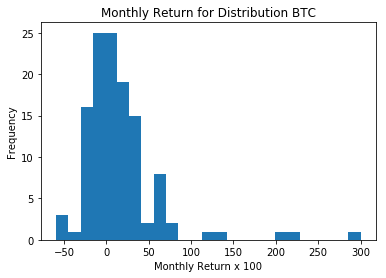

---DAILY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,-0.0005,-0.028,0.977,2.203671e-07
2.0,-0.1364,-8.319,0.000,1.862932e-02
3.0,0.0162,0.980,0.327,2.635949e-04
4.0,0.2141,13.223,0.000,4.584635e-02
5.0,0.0645,3.897,0.000,4.161680e-03
6.0,-0.0639,-3.859,0.000,4.087070e-03
7.0,-0.0421,-2.538,0.011,1.775412e-03


---WEEKLY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,0.044,1.442,0.150,0.004000
2.0,0.043,3.333,0.001,0.021081
3.0,0.043,3.783,0.000,0.027145
4.0,0.042,-0.436,0.663,0.000373


---GOOGLE INVESTOR ATTENNTION WEEKLY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,0.0174,0.346,0.730,0.000231
2.0,-0.0317,-0.628,0.530,0.000764
3.0,-0.0597,-1.175,0.240,0.002685
4.0,-0.0489,-0.980,0.328,0.001882
5.0,-0.0737,-1.431,0.153,0.004046
6.0,-0.0883,-1.777,0.076,0.006304
7.0,-0.1134,-2.276,0.023,0.010441


---WEEKLY MOMENTUM BY QUINTILE---


average_ret  t-statistic  p<|t|       r^2
rt_index quintile_index                                           
1.0      -52.111111         4.617980       -3.011  0.003  0.080908
         -5.725089         -1.233129       -0.191  0.849  0.000362
         -0.291159          3.413763        1.069  0.288  0.011077
          3.968903          2.709095        1.572  0.119  0.023660
          10.731717         7.702591        0.689  0.492  0.004633
2.0      -52.111111         2.732634       -1.635  0.105  0.025288
         -5.725089          2.021230        0.376  0.708  0.001409
         -0.291159          2.179881        0.513  0.609  0.002575
          3.968903          2.202758        0.454  0.651  0.002017
          10.731717         7.730564        2.700  0.008  0.066705
3.0      -52.111111         2.389832       -0.552  0.582  0.002953
         -5.725089         -0.132091        1.567  0.120  0.023973
         -0.291159          3.638390       -1.174  0.243  0.013327
          3.968903          3.538816        0.892  0.375  0.007732
          10.731717         6.786182        2.589  0.011  0.062223
4.0      -52.111111         1.044098       -0.840  0.403  0.006801
         -5.725089          3.781162       -0.045  0.965  0.000020
         -0.291159          4.411719        1.697  0.093  0.027460
          3.968903          2.452107        0.981  0.329  0.009447
          10.731717         3.595031       -1.470  0.145  0.020951

---GOOGLE INVESTOR ATTENNTION WEEKLY MOMENTUM BY QUINTILE---


average_ret  t-statistic  p<|t|       r^2
rt_index quintile_index                                           
1.0      -52.111111         4.617980        1.016  0.312  0.009931
         -5.725089         -1.233129       -0.864  0.390  0.007329
         -0.291159          3.413763       -1.958  0.053  0.036214
          3.968903          2.709095        0.075  0.940  0.000056
          10.731717         7.702591       -0.832  0.407  0.006746
2.0      -52.111111         2.732634        0.644  0.521  0.004011
         -5.725089          2.021230       -2.786  0.006  0.072036
         -0.291159          2.179881        0.480  0.632  0.002251
          3.968903          2.202758       -1.926  0.057  0.035085
          10.731717         7.730564       -1.408  0.162  0.019077
3.0      -52.111111         2.389832        0.179  0.858  0.000311
         -5.725089         -0.132091       -1.088  0.279  0.011688
         -0.291159          3.638390       -1.250  0.214  0.015078
          3.968903          3.538816       -3.260  0.002  0.094372
          10.731717         6.786182       -0.753  0.453  0.005578
4.0      -52.111111         1.044098        0.398  0.692  0.001534
         -5.725089          3.781162        2.909  0.004  0.078028
         -0.291159          4.411719       -0.905  0.368  0.007966
          3.968903          2.452107       -3.445  0.001  0.105151
          10.731717         3.595031       -0.661  0.510  0.004304

---------------------------------------------------*****---------------------------------------------------
---------------------------------------------------*****---------------------------------------------------


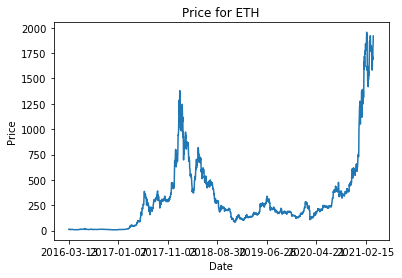

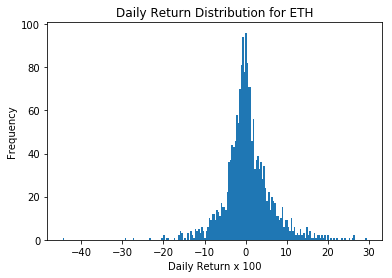

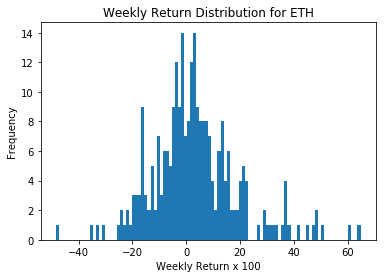

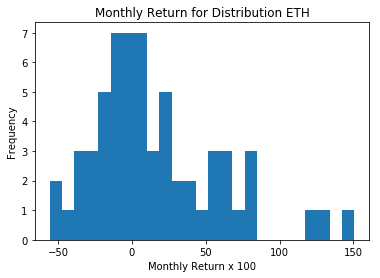

---DAILY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,-0.0352,-1.515,0.130,0.001245
2.0,0.0585,2.522,0.012,0.003445
3.0,0.0210,0.903,0.367,0.000444
4.0,-0.0048,-0.204,0.838,0.000023
5.0,0.0448,1.929,0.054,0.002031
6.0,0.0375,1.611,0.107,0.001423
7.0,-0.0134,-0.576,0.565,0.000182


---WEEKLY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,0.061,2.294,0.023,0.019836
2.0,0.062,1.814,0.071,0.012590
3.0,0.062,2.074,0.039,0.016587
4.0,0.063,-0.803,0.423,0.002562


---GOOGLE INVESTOR ATTENNTION WEEKLY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,0.0514,0.945,0.345,0.003426
2.0,0.0389,0.695,0.487,0.001871
3.0,0.0406,0.668,0.505,0.001745
4.0,0.0193,0.280,0.780,0.000311
5.0,0.0179,0.226,0.822,0.000207
6.0,-0.0707,-0.908,0.365,0.003422
7.0,-0.1344,-1.714,0.088,0.012456


---WEEKLY MOMENTUM BY QUINTILE---


average_ret  t-statistic  p<|t|       r^2
rt_index quintile_index                                           
1.0      -49.305942         1.288330       -1.570  0.123  0.046100
         -8.035901          1.962463       -1.332  0.189  0.034951
         -1.475450          1.573848       -0.472  0.639  0.004356
          4.423877          3.167704        0.428  0.670  0.003655
          12.999222         7.773373        1.245  0.219  0.029514
2.0      -49.305942        -1.549997        0.167  0.868  0.000545
         -8.035901          6.563444       -0.249  0.804  0.001294
         -1.475450          0.788288       -0.420  0.676  0.003451
          4.423877          4.701630        0.055  0.956  0.000060
          12.999222         5.520795        0.033  0.974  0.000021
3.0      -49.305942        -1.589211       -0.492  0.624  0.004733
         -8.035901          5.910499       -0.353  0.726  0.002589
         -1.475450          2.955055        0.789  0.434  0.012068
          4.423877          3.333685       -0.202  0.840  0.000819
          12.999222         5.334632        1.244  0.219  0.030011
4.0      -49.305942         3.544171       -1.661  0.103  0.051306
         -8.035901          4.855492       -1.114  0.271  0.025203
         -1.475450          2.165651       -1.107  0.274  0.023461
          4.423877          5.966716        0.347  0.730  0.002397
          12.999222        -0.309973        2.131  0.038  0.084793

---GOOGLE INVESTOR ATTENNTION WEEKLY MOMENTUM BY QUINTILE---


average_ret  t-statistic  p<|t|       r^2
rt_index quintile_index                                           
1.0      -49.305942         1.288330        0.342  0.734  0.002290
         -8.035901          1.962463       -0.564  0.576  0.006442
         -1.475450          1.573848        3.309  0.002  0.176741
          4.423877          3.167704       -0.865  0.391  0.014754
          12.999222         7.773373        0.111  0.912  0.000244
2.0      -49.305942        -1.549997       -0.112  0.911  0.000248
         -8.035901          6.563444        3.033  0.004  0.160836
         -1.475450          0.788288        1.564  0.124  0.045782
          4.423877          4.701630       -1.070  0.290  0.022380
          12.999222         5.520795       -0.947  0.348  0.017280
3.0      -49.305942        -1.589211       -0.145  0.885  0.000413
         -8.035901          5.910499        1.688  0.098  0.056011
         -1.475450          2.955055       -0.165  0.869  0.000536
          4.423877          3.333685        0.364  0.717  0.002648
          12.999222         5.334632       -0.229  0.820  0.001048
4.0      -49.305942         3.544171        0.237  0.813  0.001103
         -8.035901          4.855492       -0.480  0.633  0.004783
         -1.475450          2.165651        1.640  0.107  0.050122
          4.423877          5.966716       -1.312  0.195  0.033299
          12.999222        -0.309973        1.381  0.174  0.037440

---------------------------------------------------*****---------------------------------------------------
---------------------------------------------------*****---------------------------------------------------


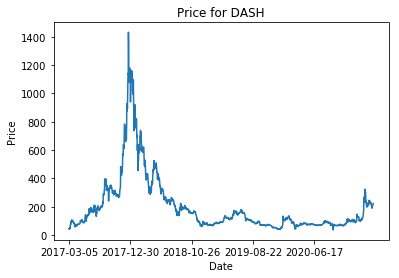

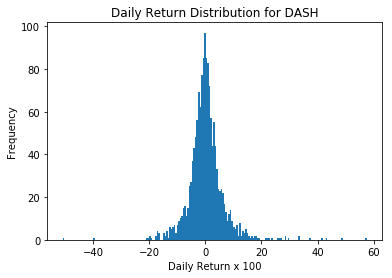

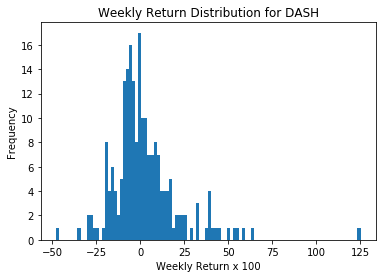

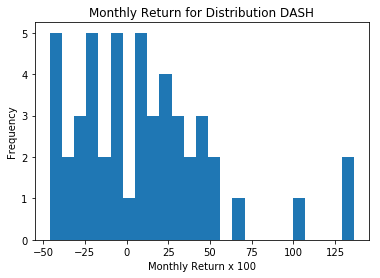

---DAILY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,-0.1088,-4.218,0.000,1.184153e-02
2.0,0.0323,1.244,0.214,1.041648e-03
3.0,0.0190,0.733,0.464,3.624428e-04
4.0,0.0080,0.308,0.758,6.440786e-05
5.0,0.0528,2.037,0.042,2.813720e-03
6.0,-0.0061,-0.235,0.814,3.780539e-05
7.0,0.0006,0.022,0.983,3.188544e-07


---WEEKLY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,0.067,1.134,0.258,0.006112
2.0,0.067,-0.186,0.853,0.000167
3.0,0.067,-0.400,0.690,0.000784
4.0,0.075,-0.554,0.580,0.001532


---GOOGLE INVESTOR ATTENNTION WEEKLY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,0.0297,0.320,0.750,0.000489
2.0,0.0626,0.678,0.499,0.002213
3.0,0.0284,0.291,0.771,0.000415
4.0,0.0411,0.418,0.677,0.000871
5.0,-0.0395,-0.448,0.655,0.001026
6.0,-0.0871,-0.985,0.326,0.005108
7.0,-0.0968,-1.082,0.281,0.006396


---WEEKLY MOMENTUM BY QUINTILE---


average_ret  t-statistic  p<|t|           r^2
rt_index quintile_index                                               
1.0      -48.827567         1.168322       -2.967  0.005  1.803930e-01
         -9.211302          0.542749       -0.835  0.408  1.714935e-02
         -4.470307          0.831149       -0.004  0.997  3.238354e-07
          1.795526          0.320981        1.271  0.211  3.879314e-02
          11.641494         6.903236        0.231  0.818  1.304244e-03
2.0      -48.827567        -2.593652       -0.664  0.511  1.088935e-02
         -9.211302          1.630488       -0.251  0.804  1.606493e-03
         -4.470307          4.834116        0.783  0.438  1.509778e-02
          1.795526          3.879806        0.160  0.874  6.368844e-04
          11.641494         1.007378       -1.602  0.117  5.888290e-02
3.0      -48.827567         5.328100        0.892  0.378  1.949693e-02
         -9.211302         -1.581901        0.581  0.565  8.583456e-03
         -4.470307          4.217816       -0.097  0.923  2.350813e-04
          1.795526          0.476894        1.289  0.205  3.985968e-02
          11.641494         0.590395        0.297  0.768  2.204344e-03
4.0      -48.827567         4.960933       -0.578  0.566  8.289979e-03
         -9.211302          3.199777       -0.035  0.973  3.067048e-05
         -4.470307          0.971201        1.795  0.080  7.635064e-02
          1.795526         -1.398038        2.185  0.035  1.066308e-01
          11.641494         2.071371        0.771  0.445  1.465062e-02

---GOOGLE INVESTOR ATTENNTION WEEKLY MOMENTUM BY QUINTILE---


average_ret  t-statistic  p<|t|       r^2
rt_index quintile_index                                           
1.0      -48.827567         1.168322        0.342  0.734  0.002909
         -9.211302          0.542749        0.699  0.489  0.012058
         -4.470307          0.831149        1.719  0.093  0.068764
          1.795526          0.320981       -1.512  0.138  0.054070
          11.641494         6.903236       -0.514  0.610  0.006412
2.0      -48.827567        -2.593652        0.197  0.845  0.000971
         -9.211302          1.630488       -0.298  0.767  0.002279
         -4.470307          4.834116        2.578  0.014  0.142486
          1.795526          3.879806       -0.118  0.907  0.000348
          11.641494         1.007378        0.568  0.573  0.007802
3.0      -48.827567         5.328100       -0.151  0.880  0.000573
         -9.211302         -1.581901       -1.608  0.116  0.062177
         -4.470307          4.217816       -0.733  0.468  0.013246
          1.795526          0.476894        1.440  0.158  0.049257
          11.641494         0.590395        1.165  0.251  0.032805
4.0      -48.827567         4.960933       -1.124  0.268  0.030643
         -9.211302          3.199777        1.235  0.224  0.037660
         -4.470307          0.971201        1.933  0.060  0.087449
          1.795526         -1.398038       -0.485  0.630  0.005852
          11.641494         2.071371        0.030  0.976  0.000023

---------------------------------------------------*****---------------------------------------------------
---------------------------------------------------*****---------------------------------------------------


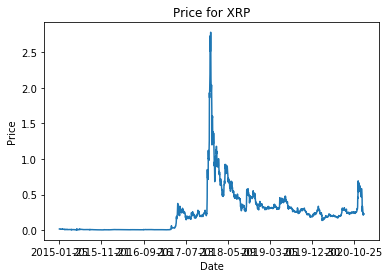

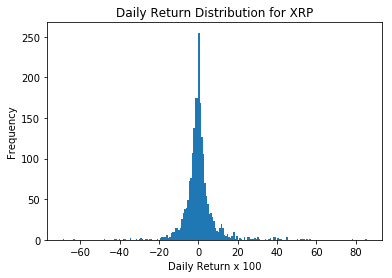

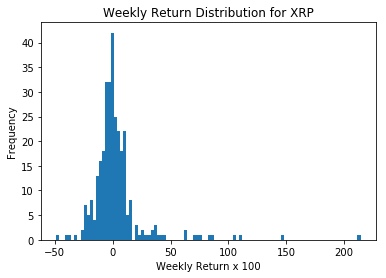

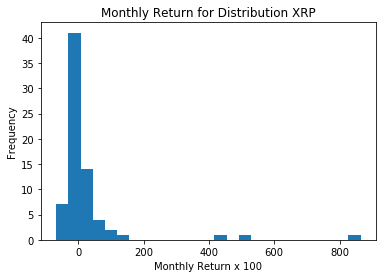

---DAILY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,-0.2090,-9.952,0.000,0.043688
2.0,0.1283,6.024,0.000,0.016478
3.0,0.0179,0.831,0.406,0.000319
4.0,0.0163,0.758,0.448,0.000266
5.0,0.0411,1.897,0.058,0.001668
6.0,-0.0113,-0.524,0.600,0.000128
7.0,0.0673,3.122,0.002,0.004532


---WEEKLY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,0.055,4.536,0.000,0.062808
2.0,0.057,2.478,0.014,0.019736
3.0,0.058,0.791,0.429,0.002070
4.0,0.059,0.565,0.572,0.001070


---GOOGLE INVESTOR ATTENNTION WEEKLY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,0.1398,0.985,0.326,0.003149
2.0,-0.0034,-0.024,0.981,0.000002
3.0,-0.1796,-1.269,0.205,0.005308
4.0,-0.2051,-1.447,0.149,0.006977
5.0,-0.1704,-1.209,0.228,0.004960
6.0,-0.1681,-1.181,0.239,0.004835
7.0,-0.2053,-1.428,0.154,0.007227


---WEEKLY MOMENTUM BY QUINTILE---


average_ret  t-statistic  p<|t|       r^2
rt_index quintile_index                                           
1.0      -49.906616         1.926816        0.724  0.472  0.008810
         -8.700225          2.820618        1.392  0.169  0.031286
         -3.025906          0.082752        1.953  0.055  0.059783
          1.347004          0.620287        1.560  0.124  0.039003
          9.018649          8.633714        3.267  0.002  0.151060
2.0      -49.906616        -0.951160        0.080  0.936  0.000111
         -8.700225          4.939754       -0.396  0.693  0.002608
         -3.025906          2.538488       -1.560  0.124  0.038958
          1.347004          0.156979       -1.304  0.197  0.027574
          9.018649          7.371722        1.436  0.156  0.033208
3.0      -49.906616        -1.103456       -1.204  0.234  0.024367
         -8.700225          3.761153        0.453  0.652  0.003408
         -3.025906          2.913399        0.692  0.491  0.007929
          1.347004          3.218789        0.146  0.885  0.000354
          9.018649          5.646510        0.023  0.982  0.000009
4.0      -49.906616        -1.117872       -0.851  0.398  0.012558
         -8.700225          4.787856       -0.200  0.842  0.000664
         -3.025906          3.292729       -0.344  0.732  0.001965
          1.347004          5.131860        1.033  0.306  0.017462
          9.018649          2.122674        0.240  0.811  0.000979

---GOOGLE INVESTOR ATTENNTION WEEKLY MOMENTUM BY QUINTILE---


average_ret  t-statistic  p<|t|       r^2
rt_index quintile_index                                           
1.0      -49.906616         1.926816       -3.015  0.004  0.133523
         -8.700225          2.820618        6.489  0.000  0.412351
         -3.025906          0.082752       -0.631  0.530  0.006599
          1.347004          0.620287        0.225  0.823  0.000845
          9.018649          8.633714        0.803  0.425  0.010622
2.0      -49.906616        -0.951160       -1.126  0.265  0.021402
         -8.700225          4.939754        1.474  0.146  0.034952
         -3.025906          2.538488        2.701  0.009  0.108404
          1.347004          0.156979       -1.610  0.113  0.041398
          9.018649          7.371722       -0.055  0.956  0.000050
3.0      -49.906616        -1.103456       -1.279  0.206  0.027410
         -8.700225          3.761153        1.448  0.153  0.033786
         -3.025906          2.913399        0.438  0.663  0.003192
          1.347004          3.218789       -0.537  0.593  0.004779
          9.018649          5.646510       -0.890  0.377  0.013248
4.0      -49.906616        -1.117872        1.062  0.293  0.019414
         -8.700225          4.787856        0.574  0.568  0.005458
         -3.025906          3.292729        1.379  0.173  0.030718
          1.347004          5.131860        1.174  0.245  0.022437
          9.018649          2.122674       -1.922  0.059  0.058939

---------------------------------------------------*****---------------------------------------------------
---------------------------------------------------*****---------------------------------------------------


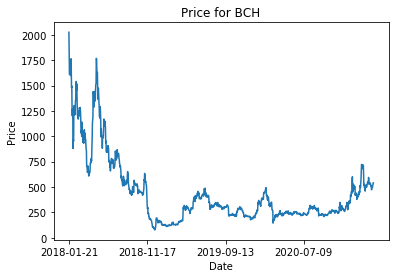

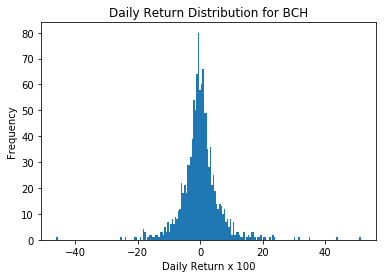

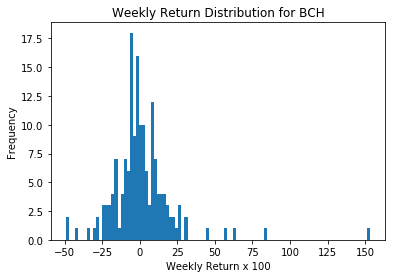

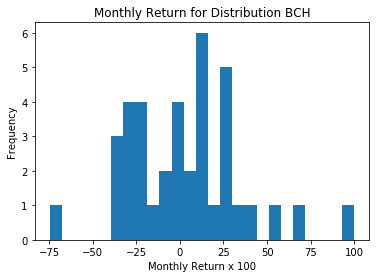

---DAILY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,-0.0053,-0.180,0.857,2.777335e-05
2.0,0.0699,2.394,0.017,4.914218e-03
3.0,0.0381,1.301,0.194,1.459430e-03
4.0,0.0365,1.244,0.214,1.338365e-03
5.0,-0.0010,-0.032,0.974,9.166261e-07
6.0,-0.0120,-0.406,0.685,1.443452e-04
7.0,-0.0255,-0.863,0.388,6.546993e-04


---WEEKLY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,0.078,-0.658,0.511,0.002653
2.0,0.078,-0.908,0.365,0.005100
3.0,0.079,-0.650,0.516,0.002671
4.0,0.081,-1.169,0.244,0.008801


---GOOGLE INVESTOR ATTENNTION WEEKLY MOMENTUM---


,beta,t-statistic,p<|t|,r^2
rt_index,,,,
1.0,-0.1353,-1.265,0.208,0.009729
2.0,-0.1146,-1.058,0.292,0.006904
3.0,-0.1384,-1.147,0.253,0.008263
4.0,0.0257,0.193,0.847,0.000242
5.0,0.3658,2.084,0.039,0.028322
6.0,0.1033,0.583,0.561,0.002369
7.0,-0.3000,-1.671,0.097,0.020114


---WEEKLY MOMENTUM BY QUINTILE---


average_ret  t-statistic  p<|t|           r^2
rt_index quintile_index                                               
1.0      -50.386076         0.026809       -0.005  0.996  9.201702e-07
         -9.822826          2.516810       -0.426  0.673  6.007661e-03
         -3.397461          1.590619       -0.021  0.983  1.464847e-05
          1.600000          1.478171        1.826  0.078  9.710533e-02
          10.301193        -0.178658       -1.173  0.250  4.252791e-02
2.0      -50.386076         3.127782       -1.374  0.179  5.743289e-02
         -9.822826          3.119948        0.716  0.479  1.680812e-02
         -3.397461         -2.743635        0.368  0.715  4.355508e-03
          1.600000          4.547167       -0.918  0.366  2.645368e-02
          10.301193        -1.928917        0.531  0.599  9.013618e-03
3.0      -50.386076        -0.378316        1.170  0.251  4.228652e-02
         -9.822826          4.747932       -0.482  0.633  7.696176e-03
         -3.397461          2.375292        0.275  0.785  2.432926e-03
          1.600000         -2.472727       -1.808  0.080  9.534984e-02
          10.301193         2.035545       -1.259  0.218  5.018884e-02
4.0      -50.386076         5.099546       -0.492  0.626  7.757302e-03
         -9.822826          0.195431       -1.558  0.130  7.484874e-02
         -3.397461         -1.899009       -0.908  0.371  2.590366e-02
          1.600000          3.528762       -1.477  0.150  6.777192e-02
          10.301193        -1.486123        0.396  0.695  5.200988e-03

---GOOGLE INVESTOR ATTENNTION WEEKLY MOMENTUM BY QUINTILE---


average_ret  t-statistic  p<|t|       r^2
rt_index quintile_index                                           
1.0      -50.386076         0.026809       -1.229  0.228  0.045065
         -9.822826          2.516810       -0.500  0.621  0.008273
         -3.397461          1.590619       -0.640  0.527  0.013045
          1.600000          1.478171        3.284  0.003  0.258062
          10.301193        -0.178658       -1.352  0.186  0.055657
2.0      -50.386076         3.127782       -0.245  0.808  0.001938
         -9.822826          3.119948        0.983  0.334  0.031189
         -3.397461         -2.743635       -0.210  0.835  0.001418
          1.600000          4.547167       -0.243  0.809  0.001909
          10.301193        -1.928917       -2.449  0.020  0.162092
3.0      -50.386076        -0.378316       -0.540  0.593  0.009318
         -9.822826          4.747932        0.873  0.390  0.024759
         -3.397461          2.375292        0.911  0.369  0.026081
          1.600000         -2.472727       -1.630  0.113  0.078909
          10.301193         2.035545       -1.115  0.274  0.039788
4.0      -50.386076         5.099546        0.832  0.412  0.021845
         -9.822826          0.195431       -0.663  0.512  0.014440
         -3.397461         -1.899009       -1.188  0.244  0.043556
          1.600000          3.528762       -1.366  0.182  0.058585
          10.301193        -1.486123        0.348  0.730  0.004016

---------------------------------------------------*****---------------------------------------------------
---------------------------------------------------*****---------------------------------------------------


In [67]:
folder = "resources/"

for filename in ["btc.csv", "eth.csv", "dash.csv", "xrp.csv", "bch.csv"]:
    data = pd.read_csv(folder + filename, parse_dates=True)
    data = preprocess(data, filename)
    
    plot_price(data)
    
    daily_df = get_daily_df(data)
    daily_df = add_google_data(daily_df, 1)
    
    plot_daily_df(daily_df)
    
    weekly_df = get_weekly_df(data)
    weekly_df =  add_google_data(weekly_df, 7)
    plot_weekly_df(weekly_df)
    
    
    monthly_df = get_monthly_df(data)
    plot_monthly_df(monthly_df)
    
    print("---DAILY MOMENTUM---")
    display(get_daily_momentum(daily_df).set_index(keys=["rt_index"]))
          
    print("---WEEKLY MOMENTUM---")
    display(get_weekly_momentum(weekly_df).set_index(keys=["rt_index"]))
          
    
    print("---GOOGLE INVESTOR ATTENTION WEEKLY MOMENTUM---")
    display(get_invatt_google_weekly(weekly_df).set_index(keys=["rt_index"]))
    
    
    #group by quintile 
    labels, quantile_df = apply_quantiles(weekly_df["ReturnW"], 5)
    weekly_df_quintile  = pd.concat([weekly_df, quantile_df.rename("quintile_idx")],
                            axis=1)
    
    print("---WEEKLY MOMENTUM BY QUINTILE---")
    display(get_group_weekly_momentum(labels, weekly_df_quintile).set_index(keys=["rt_index", "quintile_index"]))
    
    
    labels, quantile_df = apply_quantiles(weekly_df["ReturnW"], 5)
    weekly_df_google_quintile = pd.concat([weekly_df, quantile_df.rename("quintile_google_idx")], axis=1)
    
    print("---GOOGLE INVESTOR ATTENTION WEEKLY MOMENTUM BY QUINTILE---")
    display(get_group_invatt_google_weekly(labels, weekly_df_google_quintile).set_index(keys=["rt_index", "quintile_index"]))    
    
    
    print("---------------------------------------------------*****---------------------------------------------------")
    print("---------------------------------------------------*****---------------------------------------------------")